Installation and Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Mount Google Drive for Dataset Access

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


Connecting to Dataset

In [3]:
excel_path = "C:/Users/user 3/Desktop/KAN-TSM/FinalDataNN.xlsx"

df = pd.read_excel(excel_path)

# Drop rows with any NaN values in the relevant columns to avoid propagation during training
df_cleaned = df.dropna(subset=["P", "Y", "Ptest", "Ytest"])

print(df_cleaned.head())
print(df_cleaned.columns)

P_train = df_cleaned["P"].values.astype("float32")
Y_train = df_cleaned["Y"].values.astype("float32")

P_test  = df_cleaned["Ptest"].values.astype("float32")
Y_test  = df_cleaned["Ytest"].values.astype("float32")

print("Train len (P,Y):", len(P_train), len(Y_train))
print("Test  len (Ptest,Ytest):", len(P_test), len(Y_test))

   Unnamed: 0         P         Y     Ptest     Ytest
0           0  0.000869  0.941651  0.000869  0.941651
1           1  0.000869  0.941651  0.000869  0.941651
2           2  0.000869  0.941651  0.000869  0.941651
3           3  0.000869  0.941651  0.000869  0.941651
4           4  0.000869  0.941651  0.000869  0.941651
Index(['Unnamed: 0', 'P', 'Y', 'Ptest', 'Ytest'], dtype='object')
Train len (P,Y): 1072 1072
Test  len (Ptest,Ytest): 1072 1072


Displaying Time Series

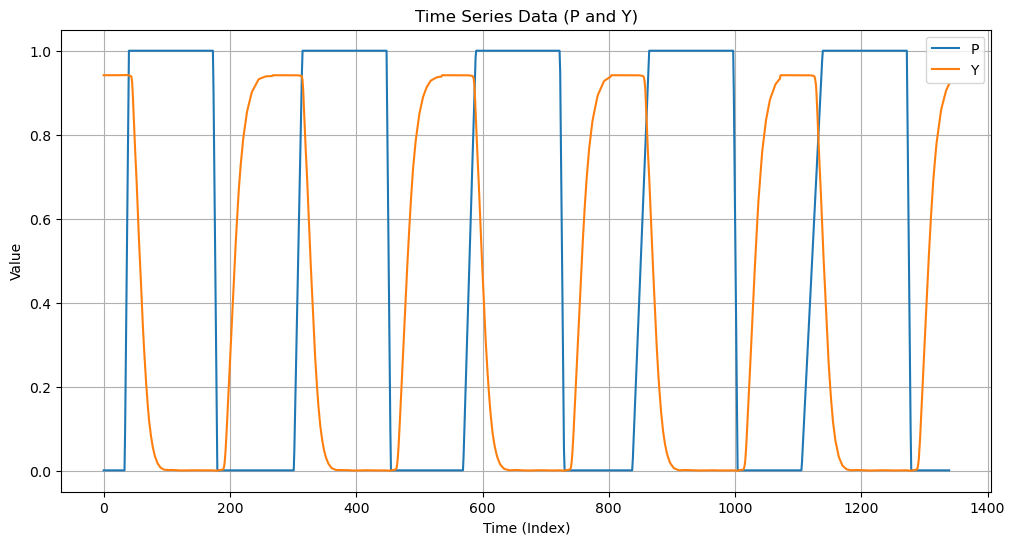

In [4]:
# Use 'P' and 'Y' columns for plotting
time_series_data_P = df['P']
time_series_data_Y = df['Y']
# Plot the time series data for 'P' and 'Y'
plt.figure(figsize=(12, 6))
plt.plot(time_series_data_P, label='P')
plt.plot(time_series_data_Y, label='Y')
plt.title('Time Series Data (P and Y)')
plt.xlabel('Time (Index)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Setting The Hyperparameters

In [23]:
K_S = 5
G_S = 3
Batch_Size = 64
Context_Len = 150
Pred_Len = 50
H_Dims = 32
N_Epochs = 5000

Sliding Window dataset with P input and Y output

In [24]:
class PairedTimeSeriesDataset(Dataset):
    def __init__(self, x_series, y_series, context_len= Context_Len, pred_len= Pred_Len):
        self.x = torch.tensor(x_series, dtype=torch.float32)
        self.y = torch.tensor(y_series, dtype=torch.float32)
        self.context_len = context_len
        self.pred_len = pred_len
        self.total_len = context_len + pred_len
        self.n_samples = len(self.x) - self.total_len + 1

    def __len__(self):
        return max(self.n_samples, 0)

    def __getitem__(self, idx):
        x_win = self.x[idx : idx + self.context_len]                  # ورودی از P
        y_win = self.y[idx + self.context_len : idx + self.total_len] # هدف از Y
        return x_win, y_win

context_len = Context_Len
pred_len = Pred_Len

train_dataset = PairedTimeSeriesDataset(P_train, Y_train, context_len, pred_len)
test_dataset  = PairedTimeSeriesDataset(P_test,  Y_test,  context_len, pred_len)

print("Train windows:", len(train_dataset))
print("Test  windows:", len(test_dataset))

batch_size = Batch_Size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

Train windows: 873
Test  windows: 873


Implementing 1D B-spline activation (simplified)

In [25]:
class BSplineActivation(nn.Module):
    def __init__(self, num_funcs, k= K_S, G= G_S):
        super().__init__()
        self.k = k
        self.G = G
        self.num_funcs = num_funcs

        # کنترل‌پوینت‌های قابل‌آموزش
        self.control_points = nn.Parameter(
            torch.randn(num_funcs, G + k) * 0.1
        )

        # گره‌ها روی [0,1]
        knots = np.linspace(0.0, 1.0, G + 1)
        start = np.full(k - 1, knots[0])
        end = np.full(k - 1, knots[-1])
        self.register_buffer(
            "knots", torch.tensor(np.concatenate([start, knots, end]), dtype=torch.float32)
        )

    def forward(self, x):
        """
        x: شکل (..., num_funcs)
        خروجی: همان شکل
        """
        orig_shape = x.shape
        x = x.view(-1, self.num_funcs)  # (B, F)
        B, F_ = x.shape
        assert F_ == self.num_funcs

        # نرمال‌سازی ستونی به [0,1]
        col_min = x.min(dim=0, keepdim=True).values
        col_max = x.max(dim=0, keepdim=True).values
        x_norm = (x - col_min) / (col_max - col_min + 1e-6)
        x_norm = x_norm.clamp(0.0, 1.0)

        t = self.knots
        k = self.k

        # پایه‌های B_{i,0}
        basis = []
        for i in range(self.G + k - 1):
            left = t[i]
            right = t[i + 1]
            b = ((x_norm >= left) & (x_norm < right)).float()
            if i == self.G + k - 2:
                b = ((x_norm >= left) & (x_norm <= right)).float()
            basis.append(b.unsqueeze(-1))  # (B, F, 1)

        basis = torch.cat(basis, dim=-1)  # (B, F, G + k - 1)

        # ارتقای مرتبه
        for deg in range(1, k):
            new_basis = []
            for i in range(self.G + k - 1 - deg):
                denom1 = (t[i + deg] - t[i])
                denom2 = (t[i + deg + 1] - t[i + 1])

                coef1 = 0.0 if denom1 == 0 else (x_norm - t[i]) / denom1
                coef2 = 0.0 if denom2 == 0 else (t[i + deg + 1] - x_norm) / denom2

                b = coef1 * basis[..., i] + coef2 * basis[..., i + 1]
                new_basis.append(b.unsqueeze(-1))
            basis = torch.cat(new_basis, dim=-1)

        # حالا basis تقریباً (B, F, G) است
        cp = self.control_points[:, :basis.shape[-1]]  # (F, G)
        y = torch.einsum("bfg,fg->bf", basis, cp)      # (B, F)
        return y.view(*orig_shape)

KAN layer and KAN network for time series

In [26]:
class ReLUKANLayer(nn.Module):
    """
    Compute ReLU-KAN basis functions and apply the final linear/convolution step.
    This follows the paper's Fig.7 / equations:
      A = ReLU(E - xT)
      B = ReLU(xT - S)
      D = r * A · B
      F = D * D
      y = conv(W, F)
    Implementation notes:
    - input_size: length n (e.g. context_len)
    - g: G (number of grids)
    - k: span parameter
    - output_size: number of outputs produced by this layer
    - is_train: whether S,E are trainable
    """
    def __init__(self, input_size: int, g: int, k: int, output_size: int, is_train: bool = False):
        super().__init__()
        self.g = g
        self.k = k
        # normalization constant per paper: r = 16 * G^4 / (k+1)^4  (paper uses variants; keep stable)
        # using float
        self.r = float(16 * (g ** 4) / ((k + 1) ** 4))
        self.input_size = input_size
        self.output_size = output_size

        # initialize phase low (S) and phase high (E) per input dimension
        # paper suggests initial si = (i - k - 1)/G , ei = i/G for each grid index i
        # We'll build matrices shaped (input_size, g + k)
        phase_low = []
        phase_high = []
        # g + k basis functions
        n_basis = g + k
        for _ in range(input_size):
            # j from 0..n_basis-1 -> use formula similar to paper: si_j = (j - k - 1) / G, ei_j = j / G
            si = [(j - (k + 1)) / float(g) for j in range(n_basis)]
            ei = [j / float(g) for j in range(n_basis)]
            phase_low.append(si)
            phase_high.append(ei)
        # register as parameters optionally trainable
        self.phase_low = nn.Parameter(torch.tensor(phase_low, dtype=torch.float32), requires_grad=is_train)
        self.phase_high = nn.Parameter(torch.tensor(phase_high, dtype=torch.float32), requires_grad=is_train)

        # We'll use a conv2d to aggregate basis outputs into output_size channels as in paper.
        # Input to conv will be shaped (batch, 1, n_basis, input_size) -> kernel (n_basis, input_size) -> output channels output_size
        # In PyTorch Conv2d terms: in_channels=1, out_channels=output_size, kernel_size=(n_basis, input_size)
        # Padding/stride set to produce a scalar per out channel (i.e., output spatial 1x1)
        self.equal_size_conv = nn.Conv2d(in_channels=1,
                                         out_channels=output_size,
                                         kernel_size=(n_basis, input_size),
                                         bias=True)

        # initialize weights reasonably
        nn.init.xavier_uniform_(self.equal_size_conv.weight)
        if self.equal_size_conv.bias is not None:
            nn.init.zeros_(self.equal_size_conv.bias)

    def forward(self, x):
        """
        x expected shape: (batch, input_size) or (batch, input_size, 1)
        We'll ensure shape (batch, input_size)
        Returns: (batch, output_size, 1) -> caller may reshape to (batch, output_size)
        """
        if x.dim() == 3 and x.size(-1) == 1:
            x = x.squeeze(-1)  # (batch, input_size)
        # x: (batch, input_size)
        batch = x.size(0)
        # expand dims to (batch, input_size, n_basis) for broadcasting with phase matrices
        # We'll move to float32
        x_exp = x.unsqueeze(-1)  # (batch, input_size, 1)
        # phase_high and phase_low are (input_size, n_basis)
        # compute A = ReLU(E - xT) -> need shapes: (batch, input_size, n_basis)
        E = self.phase_high.unsqueeze(0)  # (1, input_size, n_basis)
        S = self.phase_low.unsqueeze(0)   # (1, input_size, n_basis)
        A = F.relu(E - x_exp)             # (batch, input_size, n_basis)
        B = F.relu(x_exp - S)             # (batch, input_size, n_basis)
        # dot product A · B across input dimension? Paper uses per-input dot across basis; implementation
        # multiply elementwise then scale and square: D = r * (A * B) ; F = D * D
        D = (A * B) * self.r
        Fmat = D * D  # (batch, input_size, n_basis)

        # reshape to conv input: want (batch, 1, n_basis, input_size)
        F_conv = Fmat.permute(0, 2, 1).unsqueeze(1)  # (batch, 1, n_basis, input_size)

        out = self.equal_size_conv(F_conv)  # shape (batch, output_size, 1, 1)
        out = out.view(batch, self.output_size, -1)  # (batch, output_size, 1)
        return out  # caller may squeeze last dim


class KANTimeSeries(nn.Module):
    """
    Wrapper to build a multilayer ReLU-KAN time-series model.
    Keeps constructor signature compatible with existing code that instantiates KANTimeSeries(
        input_len=..., output_len=..., hidden_dims=(...), k=..., G=...
    )
    Forward expects x: (batch, input_len) and returns (batch, output_len)
    """
    def __init__(self, input_len: int, output_len: int,
                 hidden_dims=(H_Dims,H_Dims,H_Dims), k: int = 3, G: int = 5,
                 is_train_phase_params: bool = False):
        super().__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.k = k
        self.G = G

        # Build a stack of ReLUKANLayer layers mapping between sizes defined by hidden_dims.
        # We'll follow a convention: for time series, each layer's output_size = hidden_dims[i]
        dims = list(hidden_dims)
        layers = []
        in_size = input_len
        for out_size in dims:
            layer = ReLUKANLayer(input_size=in_size, g=G, k=k, output_size=out_size, is_train=is_train_phase_params)
            layers.append(layer)
            # after first layer, treat output as new input length = out_size (we follow paper's multi-layer concept)
            in_size = out_size

        self.layers = nn.ModuleList(layers)

        # After KAN hidden stack, map to final output_len via a small MLP / linear layer.
        # We'll collapse the final layer output (batch, last_out, 1) -> (batch, last_out)
        last_dim = dims[-1] if len(dims) > 0 else input_len
        # Final linear maps last_dim -> output_len
        self.final_linear = nn.Linear(last_dim, output_len)

    def forward(self, x):
        """
        x: (batch, input_len) or (batch, input_len, 1)
        returns: (batch, output_len)
        """
        if x.dim() == 4 and x.size(-1) == 1:
            x = x.squeeze(-1)
        out = x
        for layer in self.layers:
            y = layer(out)               # (batch, out_size, 1)
            y = y.squeeze(-1)            # (batch, out_size)
            # in KAN original there may be no activation after aggregation; keep it simple
            # use identity or small nonlinearity if desired:
            out = y

        # final mapping
        final = self.final_linear(out)   # (batch, output_len)
        return final

Model preparation, optimizer, and evaluation function

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = KANTimeSeries(
    input_len=context_len,
    output_len=pred_len,
    hidden_dims=(H_Dims, H_Dims , H_Dims),  # KAN 4-depth: [150,40,40,,40,24]
    k= K_S,
    G= G_S
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()  # MAE

def evaluate(loader):
    model.eval()
    mae = 0.0
    mse = 0.0
    n = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            mae += F.l1_loss(y_pred, y, reduction="sum").item()
            mse += F.mse_loss(y_pred, y, reduction="sum").item()
            n += y.numel()
    return mae / n, mse / n

Device: cpu


Training loop and MAE/MSE reporting on Train and Test

In [28]:
n_epochs = N_Epochs

train_history = []
test_history = []

for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    train_mae, train_mse = evaluate(train_loader)
    test_mae, test_mse = evaluate(test_loader)

    train_history.append((train_mae, train_mse))
    test_history.append((test_mae, test_mse))

    print(
        f"Epoch {epoch:03d} | "
        f"TrainLoss {running_loss/len(train_loader.dataset):.4f} "
        f"| TrainMAE {train_mae:.5f} | TestMAE {test_mae:.5f}"
    )

Epoch 001 | TrainLoss 0.3547 | TrainMAE 0.23944 | TestMAE 0.23532
Epoch 002 | TrainLoss 0.1729 | TrainMAE 0.13703 | TestMAE 0.13742
Epoch 003 | TrainLoss 0.1154 | TrainMAE 0.09929 | TestMAE 0.09906
Epoch 004 | TrainLoss 0.0905 | TrainMAE 0.08297 | TestMAE 0.08343
Epoch 005 | TrainLoss 0.0754 | TrainMAE 0.06655 | TestMAE 0.06674
Epoch 006 | TrainLoss 0.0601 | TrainMAE 0.05118 | TestMAE 0.05147
Epoch 007 | TrainLoss 0.0461 | TrainMAE 0.04056 | TestMAE 0.04139
Epoch 008 | TrainLoss 0.0361 | TrainMAE 0.03824 | TestMAE 0.03916
Epoch 009 | TrainLoss 0.0355 | TrainMAE 0.03083 | TestMAE 0.03198
Epoch 010 | TrainLoss 0.0315 | TrainMAE 0.03082 | TestMAE 0.02990
Epoch 011 | TrainLoss 0.0279 | TrainMAE 0.02455 | TestMAE 0.02371
Epoch 012 | TrainLoss 0.0237 | TrainMAE 0.02149 | TestMAE 0.02139
Epoch 013 | TrainLoss 0.0231 | TrainMAE 0.02109 | TestMAE 0.02257
Epoch 014 | TrainLoss 0.0256 | TrainMAE 0.03070 | TestMAE 0.02949
Epoch 015 | TrainLoss 0.0233 | TrainMAE 0.02353 | TestMAE 0.02371
Epoch 016 

Visualizing Predictions

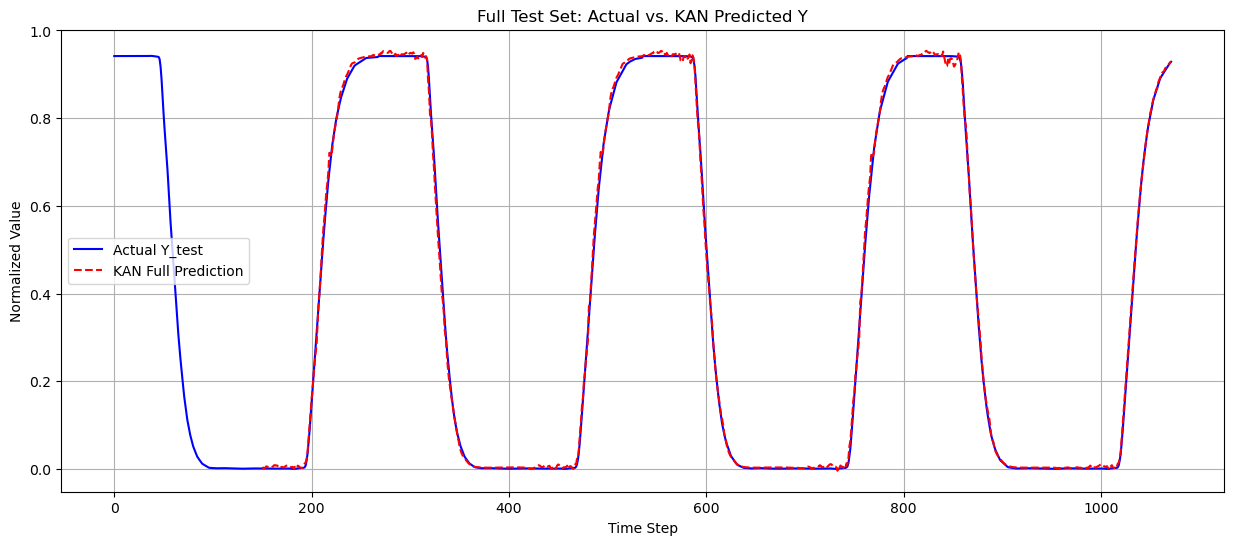

In [22]:
model.eval()

# Initialize an array to store the full reconstructed predictions
# We fill it with NaN initially so unpredicted parts are clearly visible
full_predicted_Y_test = np.full_like(Y_test, np.nan)

# Iterate through the test dataset to get predictions for each window
with torch.no_grad():
    for idx in range(len(test_dataset)):
        x_win, _ = test_dataset[idx] # We only need x_win for prediction
        x_win = x_win.unsqueeze(0).to(device) # Add batch dimension for the model
        y_pred_win = model(x_win).cpu().squeeze(0).numpy() # Get prediction and remove batch dim

        # Place the prediction into the full_predicted_Y_test array
        # This strategy uses the prediction from the latest window for overlapping steps
        start_idx = idx + context_len
        end_idx = start_idx + pred_len

        # Ensure we don't go out of bounds of Y_test
        if start_idx < len(Y_test):
            full_predicted_Y_test[start_idx : min(end_idx, len(Y_test))] = y_pred_win[:min(pred_len, len(Y_test) - start_idx)]


plt.figure(figsize=(15, 6))
# Plot the actual Y_test series
plt.plot(Y_test, label="Actual Y_test", color="blue")

# Plot the KAN model's reconstructed predictions
# We start plotting from the point where the first prediction would apply
# The initial context_len steps of Y_test are not directly predicted in this manner
plt.plot(full_predicted_Y_test, label="KAN Full Prediction", color="red", linestyle='--')

plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.title("Full Test Set: Actual vs. KAN Predicted Y")
plt.legend()
plt.grid(True)
plt.show()

Error History Plot

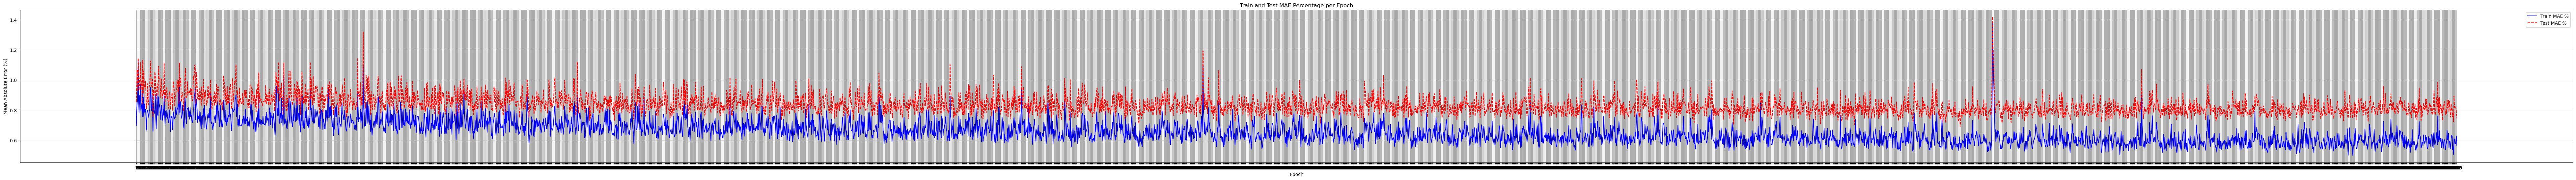

In [ ]:
# Extract MAE values from history and convert to percentage
train_mae_percent = [mae * 100 for mae, _ in train_history]
test_mae_percent = [mae * 100 for mae, _ in test_history]

epochs = range(1, len(train_mae_percent) + 1)

plt.figure(figsize=(100, 6))
plt.plot(epochs, train_mae_percent, label='Train MAE %', color='blue')
plt.plot(epochs, test_mae_percent, label='Test MAE %', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (%)')
plt.title('Train and Test MAE Percentage per Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs) # Show all epochs on x-axis
plt.show()